# Cambio1.1

### Overview
Here we'll elaborate on our carbon mass balance involving the atmosphere, land, and the oceans, by adding some diagnostics. As in Cambio1.0, but now moved outside our Euler's loop, we have the land-to-atmosphere flux,

$$
F_{land->atm} =  k_{la} \ \ \ (1) 
$$

Inside our Euler's loop, we have the usual equations,

$$
F_{atm->land} = k_{al0} +  k_{al1} [C_{atm}] \ \ \ (2)
$$

$$
F_{ocean->atm} = k_{oa} [C_{ocean}] \ \ \ (3)
$$

$$
F_{atm->ocean} = k_{ao} [C_{atm}] \ \ \ (4)
$$

$$
F_{human->atm} = \epsilon(t) \ \ \ (5)
$$

Now these are supplmented with the calulation of two *diagnostic* variables. One is the $pH$ of the upper ocean,

$$
pH = pH_{pre-industrial} - log_{10} \big ( {C_{atm} \over C_{atm,pre-industrial}} \big ) \ \ \ (6)
$$

where (as you may know) $C_{atm,pre-industrial} = 615 \ GtC$, and $pH_{pre-industrial}=8.2$. A second diagnostic variable is the global temperature anomaly,

$$
T_{anomaly} =  CS \times \big ( C_{atm}-C_{atm,pre-industrial} \big ) \ \ \ (7)
$$

where $CS$ is the climate sensitivity. Here, we'll assume an increase of three degrees Celsius for a doubling of pre-industrial $CO_2$, which translates to $CS={3 \ ^oC \over C_{atm,pre-industrial}}$.


### Euler's method
Euler's method is implemented here just as it is in Cambio1.0. Also as previously, you'll need to set things up by copying your emission scenario file into the Cambio1.0 folder, or picking it up directly from your ScheduledFlows folder.


### Skills and insights

1. Based on how a variable is situated within a given piece of code (or theoretical exposition), I can tell whether it is *prognostic*, *diagnostic*, of *parametric*.
1. I can identify when two prognostic variables are *coupled*, and whether that coupling exhibits positive or negative feedback.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5io

In [2]:
%matplotlib notebook

### Reading in the scheduled emission scenario
In the cell below, read in your scheduled emissions scenario (from ScheduledFlows). You should also plot the scenario to make sure the data are good and what you expected.

{'dataframe':             time     emissions
 0     1750.00000  1.582627e-02
 1     1750.10002  1.586589e-02
 2     1750.20004  1.590561e-02
 3     1750.30006  1.594543e-02
 4     1750.40008  1.598536e-02
 ...          ...           ...
 4995  2249.59992  9.335894e-11
 4996  2249.69994  9.172082e-11
 4997  2249.79996  9.101219e-11
 4998  2249.89998  8.935881e-11
 4999  2250.00000  8.863956e-11
 
 [5000 rows x 2 columns],
 'delta_t_trans': 20,
 'emission units': 'GtC/year',
 'eps_0': 12.4,
 'k': 0.025,
 't_0': 2018,
 't_trans': 2040}

<IPython.core.display.Javascript object>


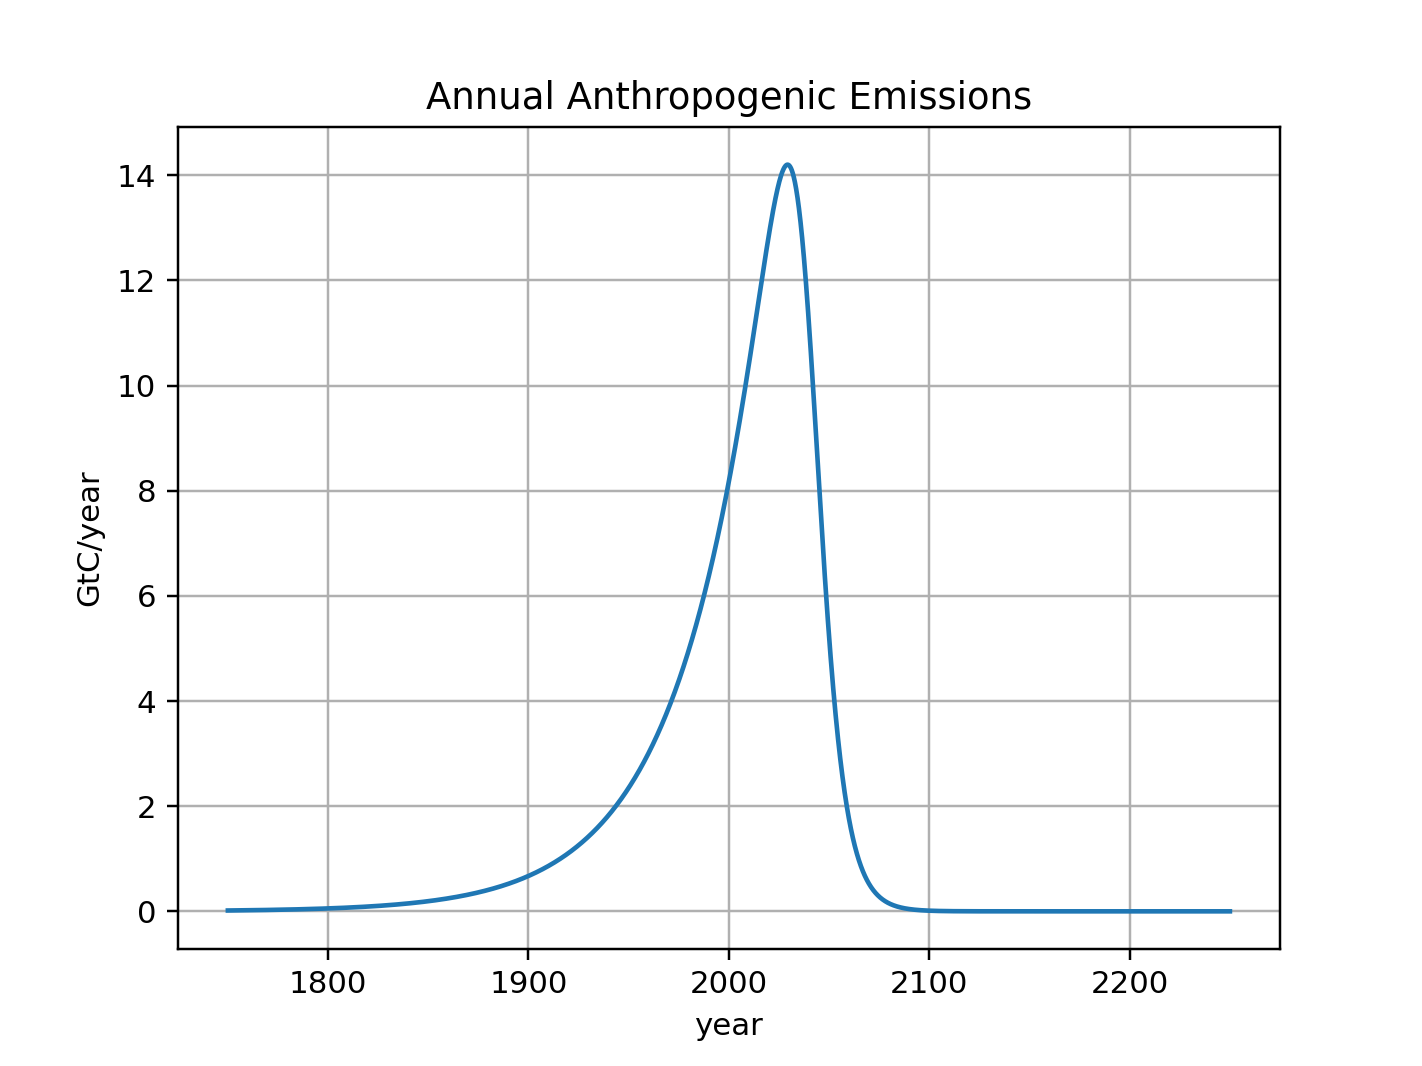

Text(0, 0.5, 'GtC/year')

In [3]:
## BEGIN SOLUTION
# Name of the file
filename = '../Week_05a.ScheduledFlows/Peaks_in_2030.hdf5'
### END SOLUTION

# This loads the stored dictionary
epsdictionary_fromfile = h5io.read_hdf5(filename)

# This shows what's in the dictionary
display(epsdictionary_fromfile)

# This extracts the dataframe from the dictionary
epsdf = epsdictionary_fromfile['dataframe']

# This extracts the time and emissions from the dataframe
time = np.array(epsdf['time'])
eps = np.array(epsdf['emissions'])

# Plotting
plt.figure()
plt.plot(time,eps)
plt.grid(True)
plt.title('Annual Anthropogenic Emissions')
plt.xlabel('year')
plt.ylabel('GtC/year')

### Rate constants and initial conditions
In the cell below, we get started with the 1st order rate constants. You'll need to calculate the time step, which you can get from the difference between the first two elements of your $t$ array.

In [4]:
# Specify pre-industrial concentrations of carbon
C_atm_preindustrial = 615
C_ocean_preindustrial = 350

# Specify the pre-industrial pH
pH_preindustrial = 8.2

# Specify rate constants
k_la = 120
k_lap = 7
k_al0 = 113
k_al1 = 0.0114
k_oa = 0.2
k_ao = 0.114

# Calculate the time step
dt = time[1]-time[0]

# Calculate the climate sensitivity, "CS"
### BEGIN SOLUTION
CS = 3/C_atm_preindustrial; print(CS)
### END SOLUTION

0.004878048780487805


### Solving the model using Euler's method
As previously, you task is to solve the model laid out in the introduction using Euler's method; the difference here is the addition of diagnostic variables $pH$ and $T_{anomaly}$. After you have done that, provide graphs of these two, in addition to the usual graphical output.

A technical note: numpy's log-base-10 function is np.log10.

<IPython.core.display.Javascript object>


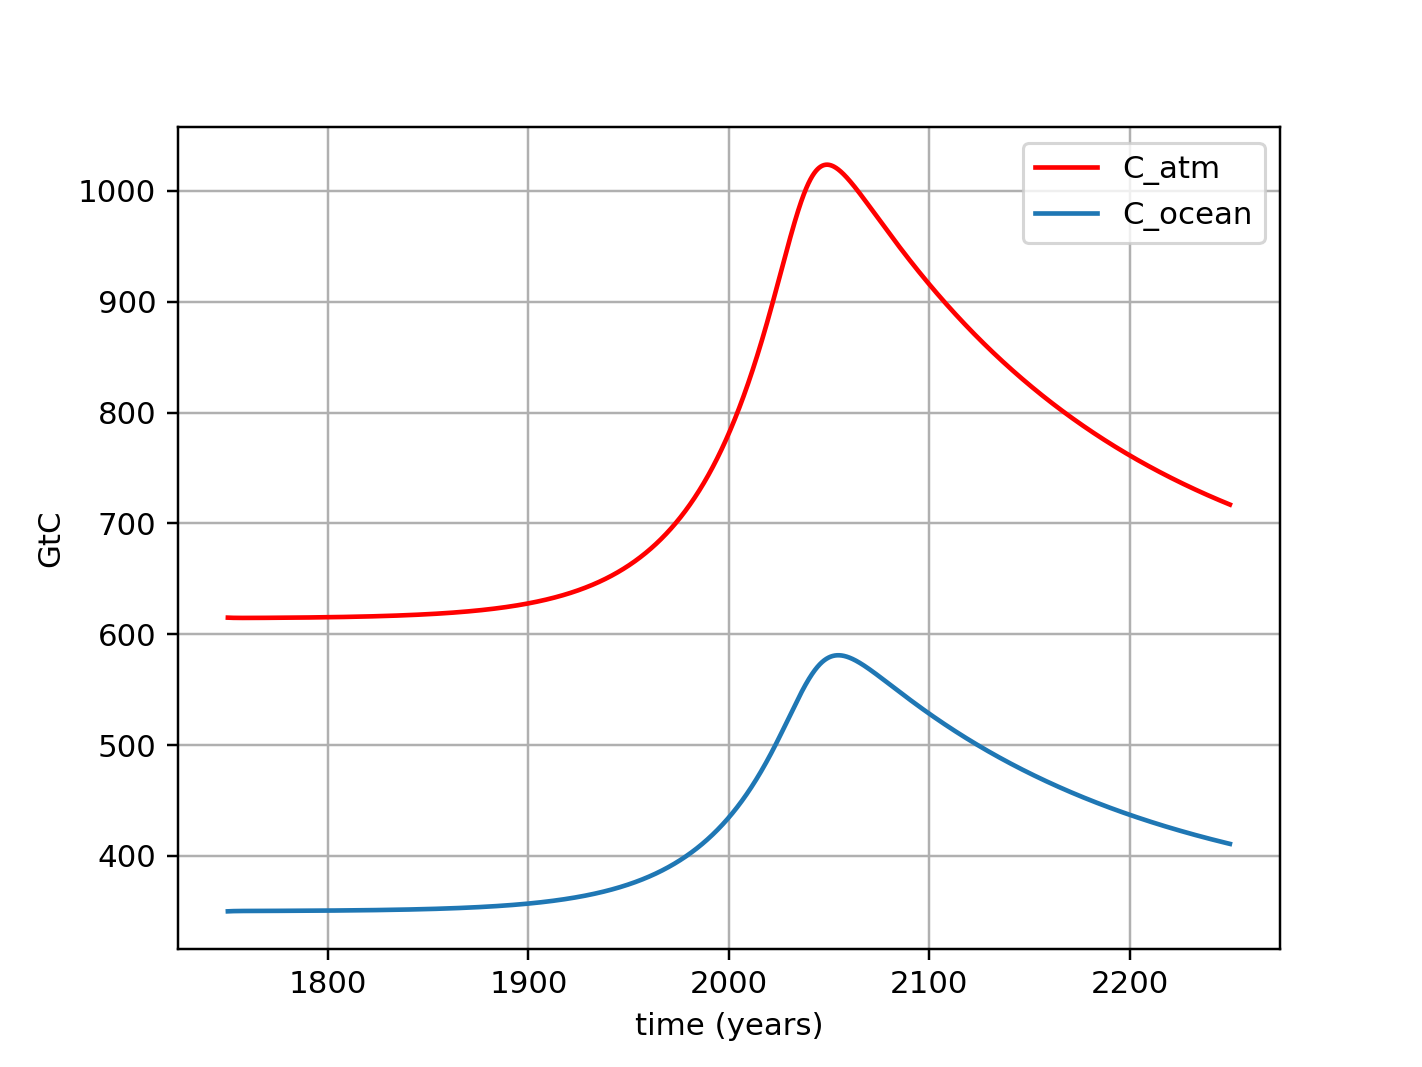

<IPython.core.display.Javascript object>


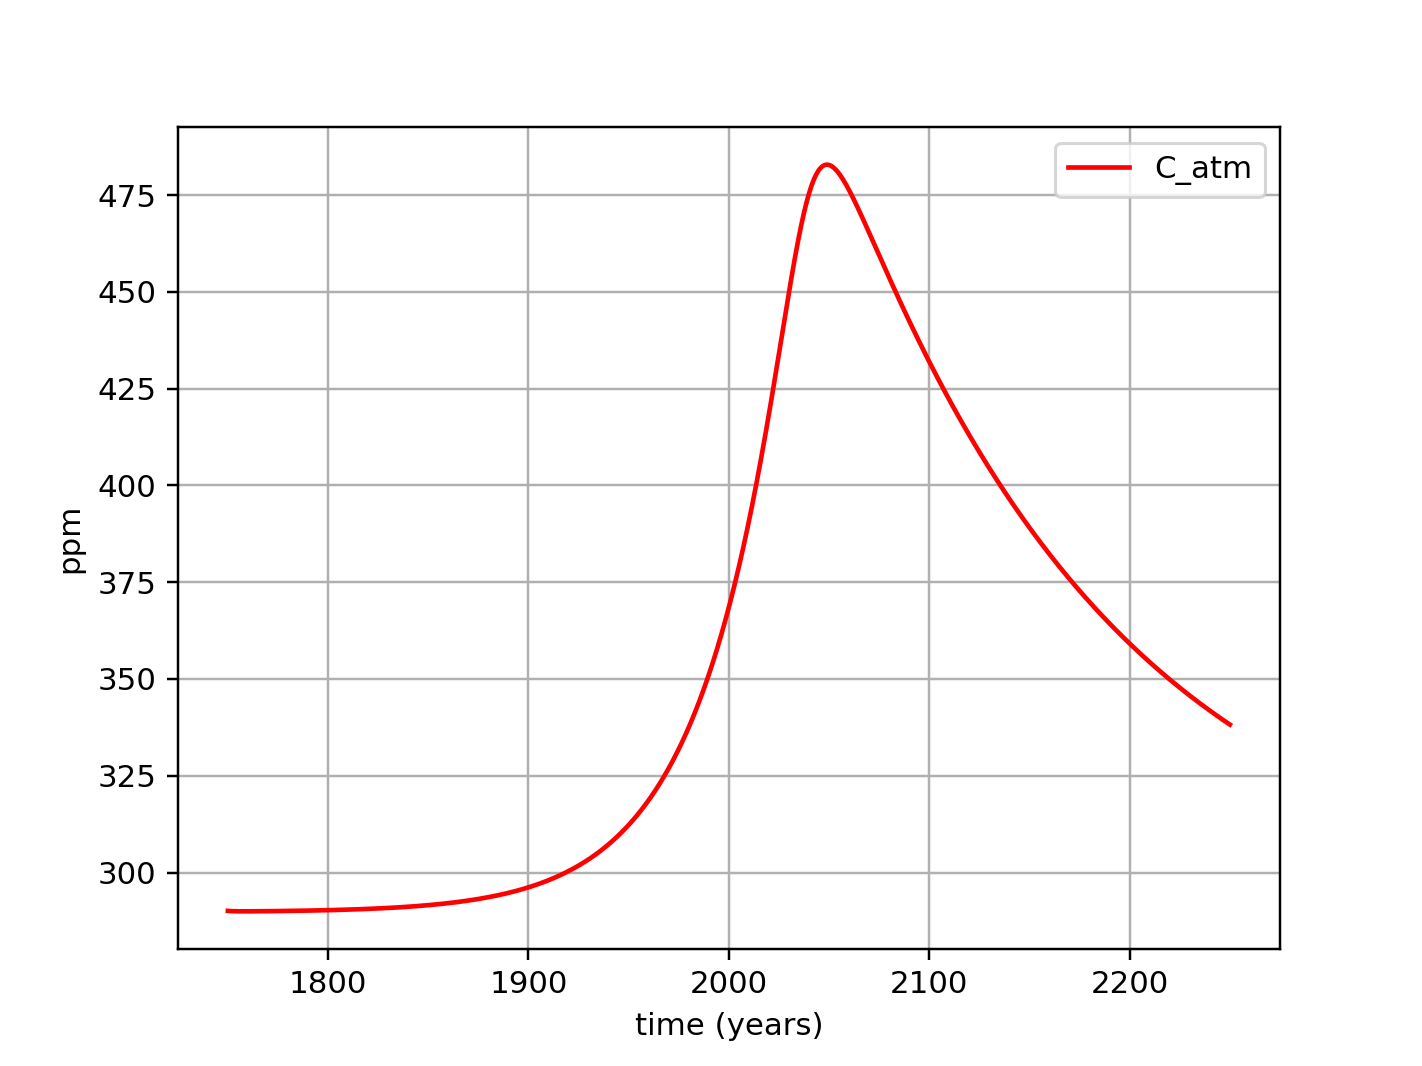

<IPython.core.display.Javascript object>


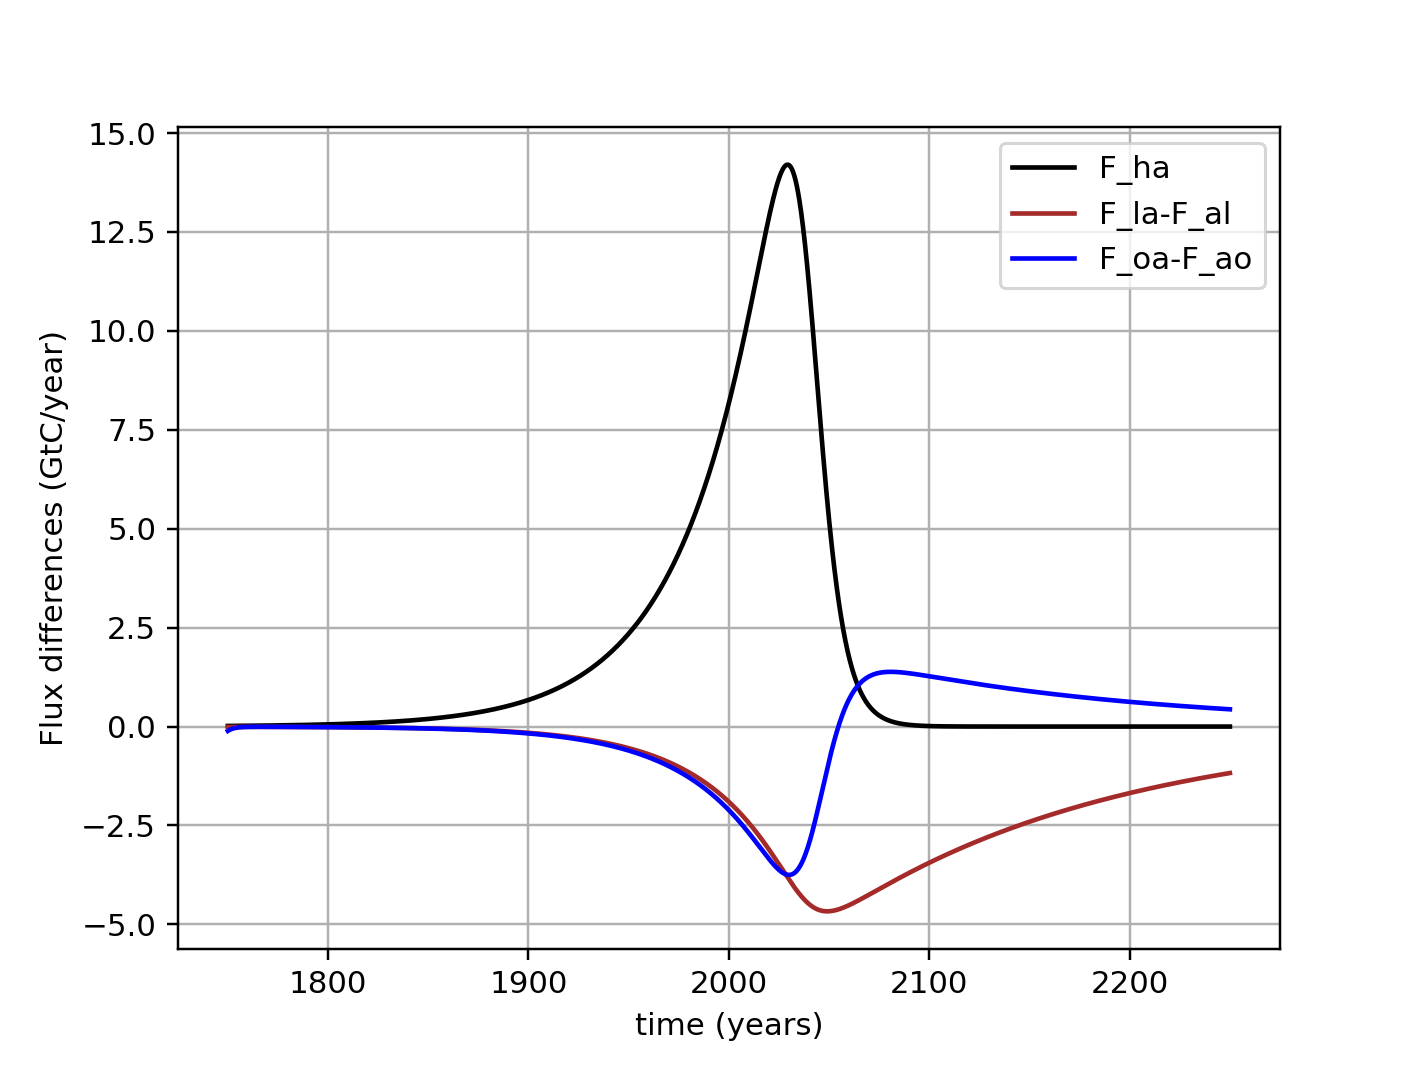

<IPython.core.display.Javascript object>


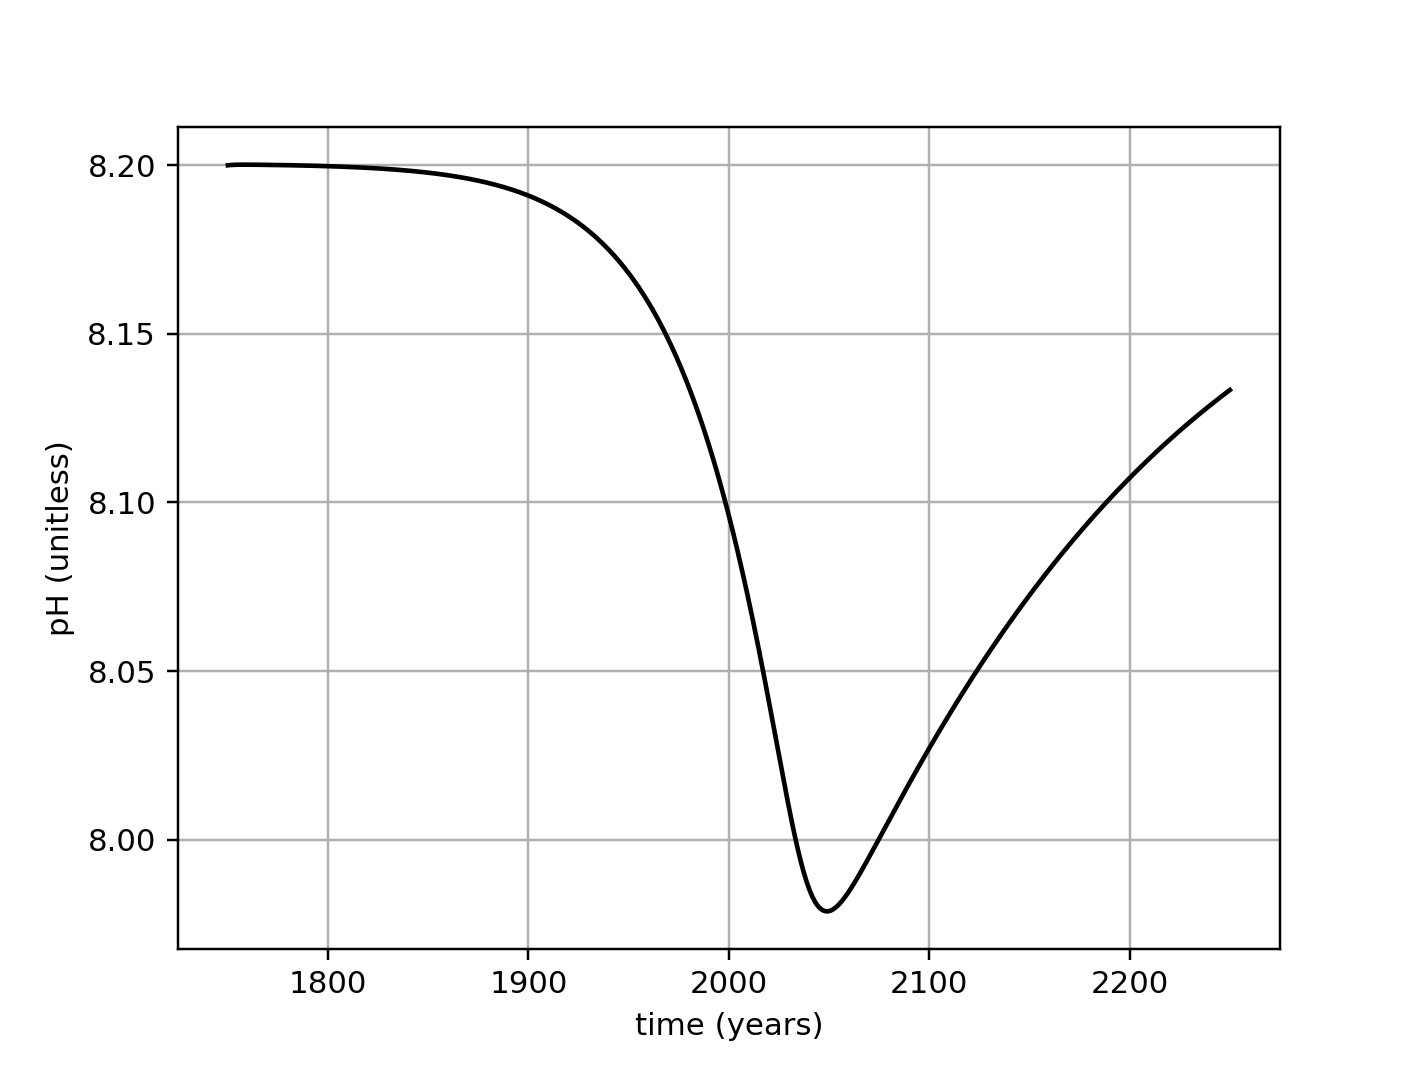

<IPython.core.display.Javascript object>


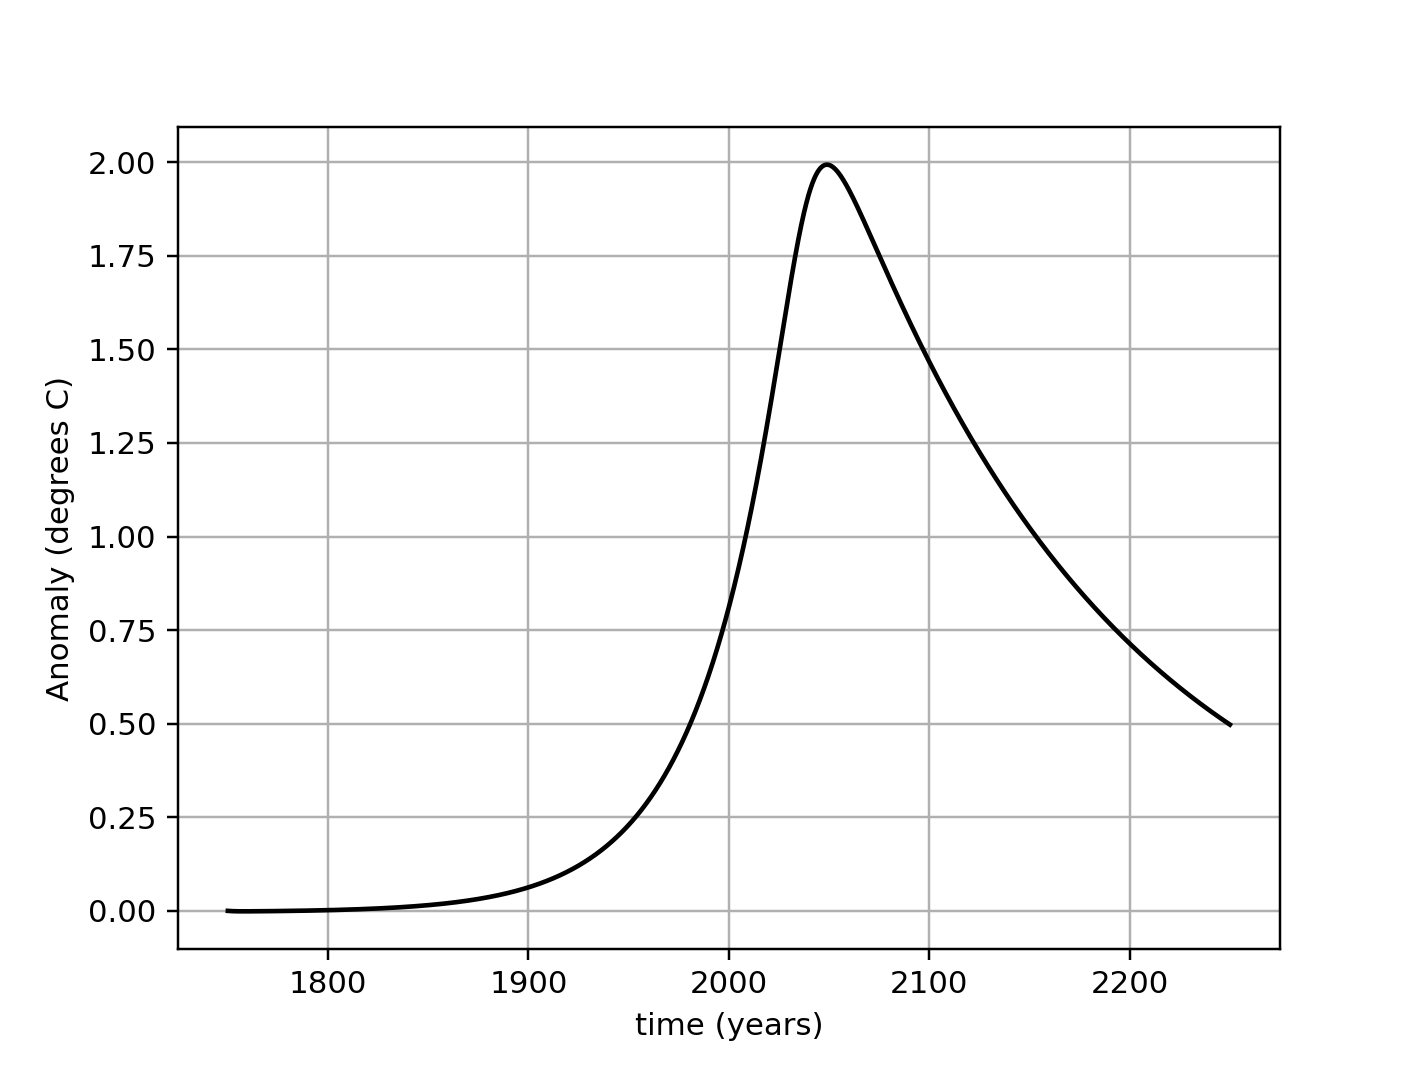

Text(0, 0.5, 'Anomaly (degrees C)')

In [5]:
# This initializes empty numpy arrays that will hold the atmospheric & oceanic carbon amounts and fluxes over time
C_atm_array = np.empty(0)
C_ocean_array = np.empty(0)
F_la_array = np.empty(0)
F_al_array = np.empty(0)
F_ao_array = np.empty(0)
F_oa_array = np.empty(0)

# Also initialize empty arrays to hold the pH and temperature anomaly
### BEGIN SOLUTION
pH_array = np.empty(0)
T_anomaly_array = np.empty(0)
### END SOLUTION

# This calculates the land-to-atmosphere flux (which doesn't need to be in the loop)
F_la = k_la

# Now we specify initial reservoir amounts in the atmosphere (C_atm) and oceans (C_ocean), in GtC. 
C_atm = C_atm_preindustrial
C_ocean = C_ocean_preindustrial

# Loop over time and use Euler's method to update, saving as you go
for i in range(len(time)):
    
    # This calculates the fluxes of this iteration of the loop
    F_al = k_al0 + k_al1*C_atm
    F_la = k_la
    F_oa = k_oa*C_ocean
    F_ao = k_ao*C_atm
    
    # This calculates the change in C_atm and C_ocean
    delta_C_atm = (F_la + F_oa - F_ao - F_al + eps[i])*dt
    delta_C_ocean = (F_ao - F_oa)*dt
    
    # This updates C_atm and C_ocean amounts
    C_atm += delta_C_atm
    C_ocean += delta_C_ocean
    
    # Append to arrays for looking at later
    C_atm_array = np.append(C_atm_array,C_atm)
    C_ocean_array = np.append(C_ocean_array,C_ocean)
    F_la_array = np.append(F_la_array,F_la)
    F_al_array = np.append(F_al_array,F_al)
    F_oa_array = np.append(F_oa_array,F_oa)
    F_ao_array = np.append(F_ao_array,F_ao)
    
    # Calculate the pH and temperature anomaly for this step, and append them to arrays
### BEGIN SOLUTION
    pH = pH_preindustrial - np.log10(C_atm/C_atm_preindustrial)
    pH_array = np.append(pH_array,pH)
    T_anomaly = CS*(C_atm-C_atm_preindustrial)
    T_anomaly_array = np.append(T_anomaly_array,T_anomaly)
### END SOLUTION

# Plotting the concentrations (C_atm and C_ocean) on one graph, in GtC
plt.figure('Carbon in the atmosphere and oceans')
plt.plot(time,C_atm_array,'red',label='C_atm')
plt.plot(time,C_ocean_array,label='C_ocean')
plt.grid(True)
plt.xlabel('time (years)')
plt.ylabel("GtC")
plt.legend()

# Plotting the atmospheric concentration (C_atm), in ppm (by dividing C_atm by 2.12)
plt.figure('Carbon in the atmosphere converted to ppm')
plt.plot(time,C_atm_array/2.12,'red',label='C_atm')
plt.grid(True)
plt.xlabel('time (years)')
plt.ylabel("ppm")
plt.legend()

# Plotting the net fluxes
plt.figure('Net fluxes (into - out of atmosphere) and anthropogenic input to atmosphere (GtC/year)')
F_land_net = F_la_array-F_al_array
F_ocean_net = F_oa_array-F_ao_array
F_impact = eps +F_land_net +F_ocean_net
plt.plot(time,eps,label='F_ha',color='black')
plt.plot(time,F_land_net,label='F_la-F_al',color='brown')
plt.plot(time,F_ocean_net,label='F_oa-F_ao',color='blue')
plt.grid(True)
plt.xlabel('time (years)')
plt.ylabel("Flux differences (GtC/year)")
plt.legend()

# Plot the pH
### BEGIN SOLUTION
plt.figure('pH')
plt.plot(time,pH_array,label='pH',color='black')
plt.grid(True)
plt.xlabel('time (years)')
plt.ylabel("pH (unitless)")
### END SOLUTION

# Plot the temperature anomaly
### BEGIN SOLUTION
plt.figure('Temperature anomaly')
plt.plot(time,T_anomaly_array,label='Temperature anomaly',color='black')
plt.grid(True)
plt.xlabel('time (years)')
plt.ylabel("Anomaly (degrees C)")
### END SOLUTION

### Pause for analyis
In the cell below, do a little reporting on your results:

1. How low (acidic) did the ocean's pH get in your scenario, in what year did it reach that minimum, and how does that timing compare to maxima in other variables (emissions, concentrations)?
1. How hot did the planet get in your scenario, in what year did it reach that maximum, and how does that timing compare to maxima in other variables?
1. We know that $C_{atm}$ and $C_{ocean}$ are prognostic variables. But of the other variables appearing in Eqs. (1-7), which are prognostic, which are diagnostic, and which are parametric?

### BEGIN SOLUTION


### END SOLUTION

### Refresh/save/validate
Double-check everything is OK, and press the "Validate" button (as usual).

### Close/submit/logout
Close, submit, and log out.